## JDSZR6, Jonasz Krawczyk
### PD11

### treść zadania:
Na podstawie danych zawartych w zbiorze https://www.kaggle.com/mlg-ulb/creditcardfraud 
dotyczącym wyłudzeń transakcji kartowych, stwórz model SVM oraz lasu losowego, 
który szacować będzie ryzyko wyłudzenia.

W zadaniu muszą pojawić się co najmniej takie punkty jak:

Podział zbioru na treningowy i testowy
Ocena jakości każdego z modeli oraz wybór lepszego z nich.
Wybór poziomu cut-off, który pozwoli na jak najlepsze wykrywanie fraud'ów 
(Zastanów się, co jest dla Ciebie gorszą sytuacją błędne przypisanie frauda 
zwykłej transakcji czy uznanie zwykłej transakcji za fradu). Uargumnetuj swój wybór.
Zadania dodatkowe (ekstra punkty!):

Wydziel również zbiór walidacyjny, na którym sprawdzisz czy wybrany, ostateczny model 
zachowuje jakość.
Fraud jest zdarzeniem rzadkim. Istnieją metody, które pozwalają na lepsze 
rozpoznanie tego typu zjawisk, mogą to być na przykład oversampling lub undersampling. 
Użyj jednej z tych metod.
Uwagi:

Zbiór cech jest wynikiem analizy głównych składowych (ang. PCA) - 
metody zmniejszającej wymiarowość (liczbę cech objaśniających). 
Możecie znaleźć wiele ciekawych materiałów na ten temat w internecie. 
W powyższym zadaniu nie ma jednak konieczności poznawania szczegółów tej metody. 
Dla celów naukowych, możecie sprawdzić średnią i odchylenie standardowe każdej ze zmiennych.

--------

wczytanie pakietów

In [57]:
pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)
Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from imblearn import under_sampling as us
from collections import Counter

from numpy import sqrt
from numpy import argmax

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, roc_curve, plot_roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. pobranie danych, wgląd

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.shape

(284807, 31)

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [9]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### 2. analiza danych

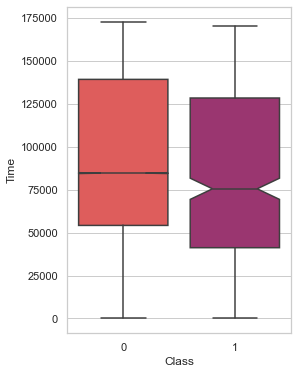

In [10]:
plt.figure(figsize=(4, 6))
sns.set_theme(style="whitegrid")
g = sns.boxplot(x='Class',
                y='Time',
                data=df,
                notch=True,
                palette='flare',
                saturation=5)

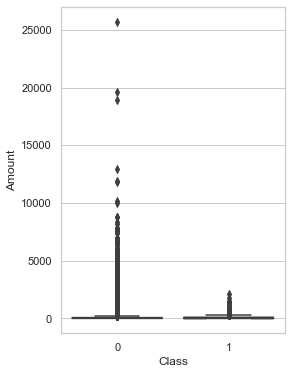

In [11]:
plt.figure(figsize=(4, 6))
sns.set_theme(style="whitegrid")
g = sns.boxplot(x='Class',
                y='Amount',
                data=df,
                notch=True,
                palette='flare',
                saturation=5)

Widać tu sporo outlierów. Nie będę ich jednak usuwał bo dotyczą wysokości kredytu, ta w zasadzie może być dowolna, w zależności potrzeb i możliwości kredytobiorcy.

Fraudy występują raczej dla małych kwot. Prawdopodobnie dla kredytów o dużej wartości wnioski są rozpatrywane bardziej skrupulatnie.

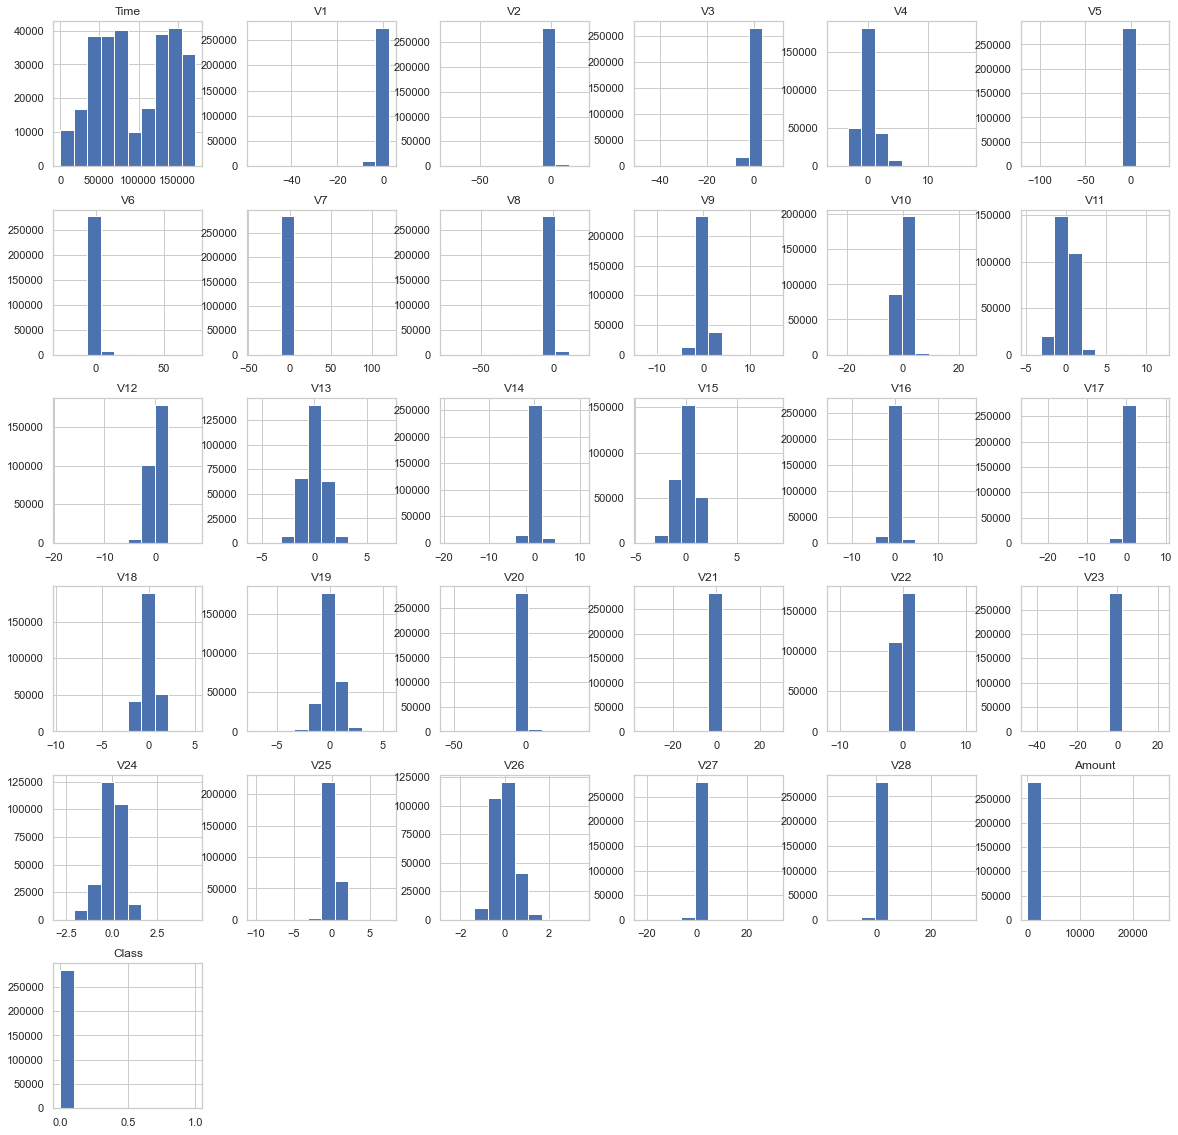

In [12]:
df.hist(figsize=(20,20))
plt.show()

sprawdzę jeszcze korelację zmiennych

In [13]:
correlation_matrix = np.round(df.corr(), 3)

In [14]:
cor_ranking = df.corr()['Class'].sort_values(ascending = False)
cor_ranking_abs = abs(cor_ranking)
cor_ranking_abs.sort_values(ascending = False)

Class     1.000000
V17       0.326481
V14       0.302544
V12       0.260593
V10       0.216883
V16       0.196539
V3        0.192961
V7        0.187257
V11       0.154876
V4        0.133447
V18       0.111485
V1        0.101347
V9        0.097733
V5        0.094974
V2        0.091289
V6        0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time      0.012323
V28       0.009536
V24       0.007221
Amount    0.005632
V13       0.004570
V26       0.004455
V15       0.004223
V25       0.003308
V23       0.002685
V22       0.000805
Name: Class, dtype: float64

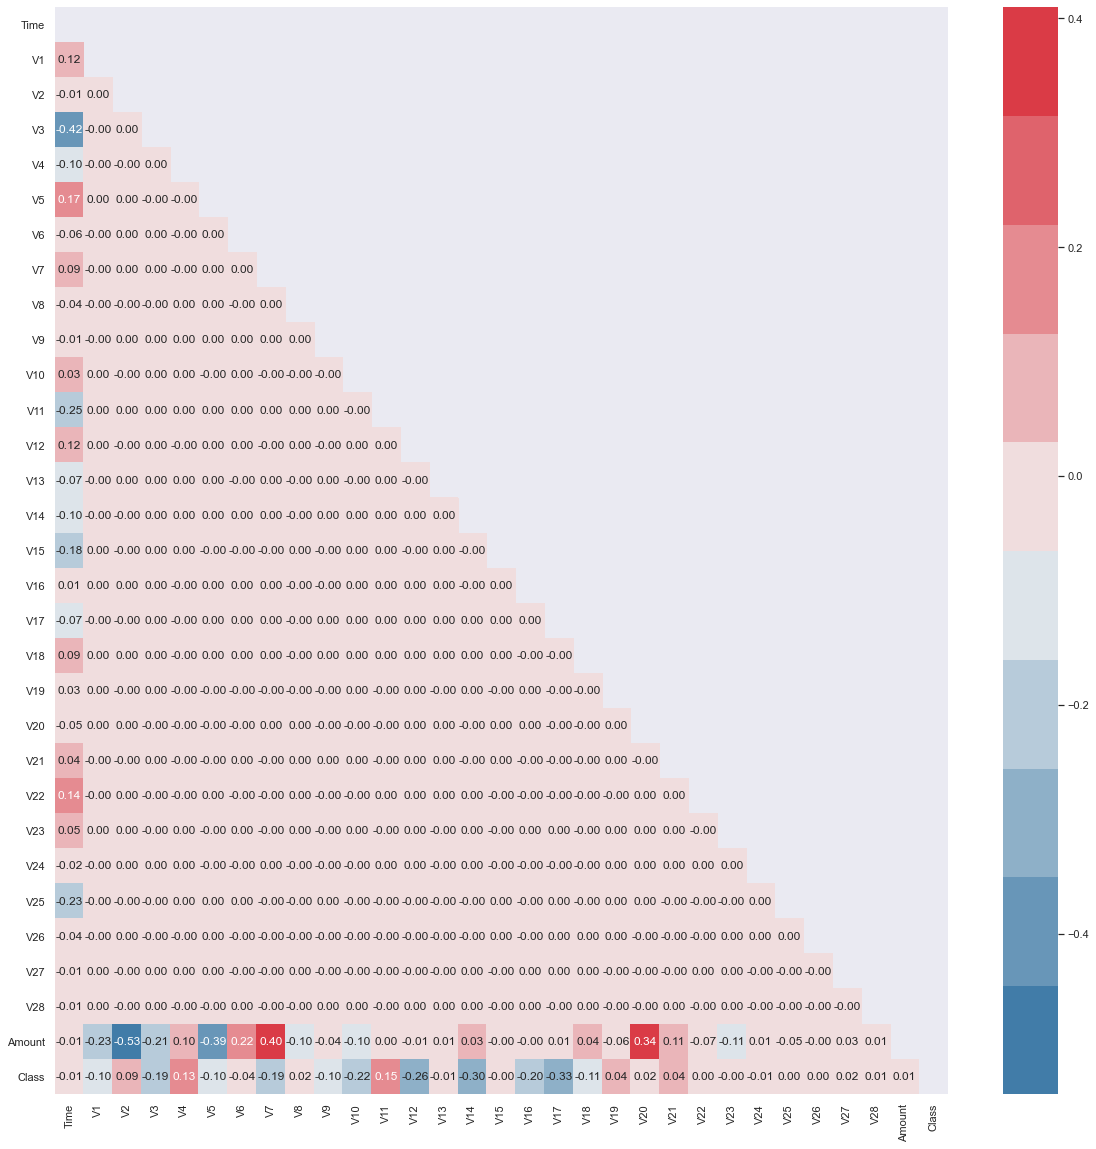

In [15]:
sns.set(rc={'figure.figsize': (20, 20)})
color_map = sns.diverging_palette(240, 10, n=10)
mask = np.triu(np.ones_like(correlation_matrix), k=0)
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap=color_map,
            vmin=-0.54,
            vmax=0.41)
pass

Dane są zanonimizowane, w zasadzie nie mamy możliwości dowiedzieć się co oznaczają zmienne V1 - V28. Wśród nich są czynniki które zdają się mieśc wpływ na zjawisko Frauda - w szczególności V10, V12, V14, V17.

Jedyne opisane kolumny Time i Amount nie są skorelowane z Class. Dataset jest więc mało interesujący dla osoby, która nie zna właściwych znazw pod pozostałymi zmiennymi. Nawet po rozwiązaniu zadania (po za przećwiczeniem tematyki ML) nie ma tu szans na poznanie jakichś zależności branżowych i wyciągnięcie wniosków w tym zakresie.

### 3. przygotowanie zbiorów

Niestety bardzo dużo czasu spędzam na samych obliczeniach!
Nie jestem w stanie wykonać ćwiczenia na całym zbiorze- na potrzeby pracy domowej muszę tutaj sprawę mocno ograniczyć.
Muszę pousuwać część zmiennych, pozostawię tylko te najsilniej skorelowane. Pomniejszę też wielkości zbiorów.
W rzeczywistej pracy raczej bym poprosił o mocniejszy komputer, lub przydzielenie większej ilości czasu na zadanie.
Nie chcę spędzać nad tym reszty dzieciństwa więc kroję ile się da.

In [16]:
df1 = df.loc[:99999, ['V10', 'V12', 'V14', 'V16', 'V17', 'Class']]

In [17]:
df1["Class"].value_counts()

0    99777
1      223
Name: Class, dtype: int64

In [18]:
X = df1[['V10', 'V12', 'V14', 'V17', 'V16']]
y = df1['Class']

Przygotuję tu od razu zbiór walidacyjny, może się później przydać.

Przyłożę proporcję 50:25:25

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=606)

In [20]:
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=606)

kontrola zbiorów

In [21]:
print(len(X_train))
print(len(X_test))
print(len(X_val))
total_len_x = (len(X_train)+len(X_test)+len(X_val))
print(df1.shape[0] == total_len_x)
print()
print(len(y_train))
print(len(y_test))
print(len(y_val))
total_len_y = (len(y_train)+len(y_test)+len(y_val))
print(df1.shape[0] == total_len_y)

50000
25000
25000
True

50000
25000
25000
True


dane są po analizie PCA, nie będę ich standaryzował.

### 4. SVM - zadekretowanie i strojenie modelu

In [22]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [23]:
y_pred_svm=svm_model.predict(X_test)
y_pred_proba_svm=svm_model.predict_proba(X_test)
positive_proba_svm = y_pred_proba_svm[:, 1]

In [24]:
print("SVM AUC            : ", roc_auc_score(y_test,positive_proba_svm))
print("SVM precision score: ", precision_score(y_test,y_pred_svm))
print("SVM F1 score       : ", f1_score(y_test,y_pred_svm))

SVM AUC            :  0.9337992377005537
SVM precision score:  0.972972972972973
SVM F1 score       :  0.7659574468085106


Drobna próba dostrojenia modelu. (robię ile mogę, tylko poniższy fragment zabrał mojemu komputerowi ok. 15 min.)

In [66]:
param_grid = {'gamma': np.linspace(0, 1, 11), 'C': range(1, 11, 1)}

random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=param_grid,
    cv=3,
    n_iter=5,
    verbose=1,
    scoring='roc_auc',
    random_state=606)
random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'gamma': 1.0, 'C': 5}

In [25]:
svm_model_opt = SVC(gamma=1.0, C=5, probability=True)
svm_model_opt.fit(X_train, y_train)

SVC(C=5, gamma=1.0, probability=True)

In [26]:
y_pred_svm_opt=svm_model_opt.predict(X_test)
y_pred_proba_svm_opt=svm_model_opt.predict_proba(X_test)
positive_proba_svm_opt = y_pred_proba_svm_opt[:, 1]

In [27]:
print("SVMopt AUC            : ", roc_auc_score(y_test,positive_proba_svm_opt))
print("SVMopt precision score: ", precision_score(y_test,y_pred_svm_opt))
print("SVMopt F1 score       : ", f1_score(y_test,y_pred_svm_opt))

SVMopt AUC            :  0.9258832946134731
SVMopt precision score:  0.9230769230769231
SVMopt F1 score       :  0.34285714285714286


Tak, w tym przypadku lepiej pozostawić domyślne parametry modelu. Niekoniecznie od razu zrobiłem coś źle z optymalizacją ale należy mieć z tyłu głowy, że to randomsearch więc i tak nie jest jakoś super skrupulatny, do tego nie pracujemy na danych z całego zbioru ale na jego okrojonej wersji.

Z drugiej strony - domyślne parametry gamma i C ustawione na "auto" / "scale" - widać, że deweloperzy biblioteki dobrze przeymyśleli sprawę i można im zawierzyć.

### 5. las losowy - ustanowienie modelu i jego optymalizacja

In [28]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
y_pred_rf=rf_model.predict(X_test)
y_pred_proba_rf=rf_model.predict_proba(X_test)
positive_proba_rf = y_pred_proba_rf[:, 1]

In [30]:
print("RF AUC score      : ", roc_auc_score(y_test,positive_proba_rf))
print("RF precision score: ", precision_score(y_test,y_pred_rf))
print("RF F1 score       : ", f1_score(y_test,y_pred_rf))

RF AUC score      :  0.920064765208535
RF precision score:  0.9772727272727273
RF F1 score       :  0.8514851485148516


ponownie jk w SVM, tutaj też dokonam próby optymalizacji.

In [72]:
param_grid = {'max_depth': range(3,8), 'min_samples_leaf': range(3, 21, 3)}

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid,
    cv=3,
    n_iter=5,
    verbose=1,
    scoring='roc_auc',
    random_state=606)
random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'min_samples_leaf': 15, 'max_depth': 4}

In [31]:
rf_model_opt = RandomForestClassifier(min_samples_leaf=15, max_depth=4)
rf_model_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=15)

In [32]:
y_pred_rf_opt=rf_model_opt.predict(X_test)
y_pred_proba_rf_opt=rf_model_opt.predict_proba(X_test)
positive_proba_rf_opt = y_pred_proba_rf_opt[:, 1]

In [33]:
print("RFopt AUC score      : ", roc_auc_score(y_test,positive_proba_rf_opt))
print("RFopt precision score: ", precision_score(y_test,y_pred_rf_opt))
print("RFopt F1 score       : ", f1_score(y_test,y_pred_rf_opt))

RFopt AUC score      :  0.9752407418739286
RFopt precision score:  0.8035714285714286
RFopt F1 score       :  0.7964601769911505


Tym razem rzecz uległa polepszeniu, ale tylko w ujęciu pola pod krzywą ROC. Pozostałe parametry spadły.

### 6. wybór modelu

Do oceny modeli nie nadaje się metryka Accuracy ze względu na niezbilansowany charakter danych. Jest o tym także wspomniane w opisie tego datasetu na Kaglu. 

Modele będę oceniał stosując wartość pola pod krzywą ROC. 
Zdecydowałem, że w tym temacie ważne jest wykrycie Fraudu i model powinien być przedewszystkim skuteczny w jego określaniu. Powinien to robić dobrze nawet kosztem tego, że częściej miałby błędnie przypisywać fraud transakcjom w rzeczywistosci legalnym. Znaczy się będzie źle jeśli rzeczywisty fraud zostanie przegapiony. W tym przypadku lepiej przypisać ich więcej i np. oddać potem do ręcznej analizy przez pracownika kredytodawcy. Drugą metryką przy ocenie jest więc PositivePredictiveValue.

Metryka F-1 występuje w ramach wsparcia, przyzwyczaiłem się do jej obecności. Dla mnie stanowi ogólny obraz modelu.

Z czterech dostępnych modeli najkorzystniejszym jest zoptymalizowany las losowy. Tak wskazuje przyjęte kryterium oceny modelu - pole pod krzywą ROC. Jednocześnie - pozostałe parametry: precyzja i f1_score spadły tak bardzo, że nie mogę tego pominąć. Nie są dla mnie tak istotne jak AUC ale szczególnie razi mnie precision które z blisko 1 spadło na ok. 0.8.
Ostatecznie wybieram model domyślnego lasu losowego.

sprawdzę jeszcze gościa na zbiorze walidacyjnym, skoro już pokusiłem się o stworzenie go.

In [34]:
y_pred_rfv=rf_model.predict(X_val)
y_pred_proba_rfv=rf_model.predict_proba(X_val)
positive_proba_rfv = y_pred_proba_rfv[:, 1]

In [35]:
print("RFv AUC score      : ", roc_auc_score(y_val, positive_proba_rfv))
print("RFv precision score: ", precision_score(y_val, y_pred_rfv))
print("RFv F1 score       : ", f1_score(y_val, y_pred_rfv))

RFv AUC score      :  0.9559650803657589
RFv precision score:  0.9777777777777777
RFv F1 score       :  0.854368932038835


Wyniki są porównywalne (powtarzalne), chociaż widać zwiększenie AUC. Zbiór walidacyjny się przydał, choćby do tego aby pokusić się o stwierdzenie, że to moje przycięcie datasetu nie było takim znowu dużym nadużyciem.

### 7. cut-off

zastanawiam się, czy szukanie cut-off ma sens dla danych po PCA

Best cut-off: 0.110000, G-Mean: 0.917


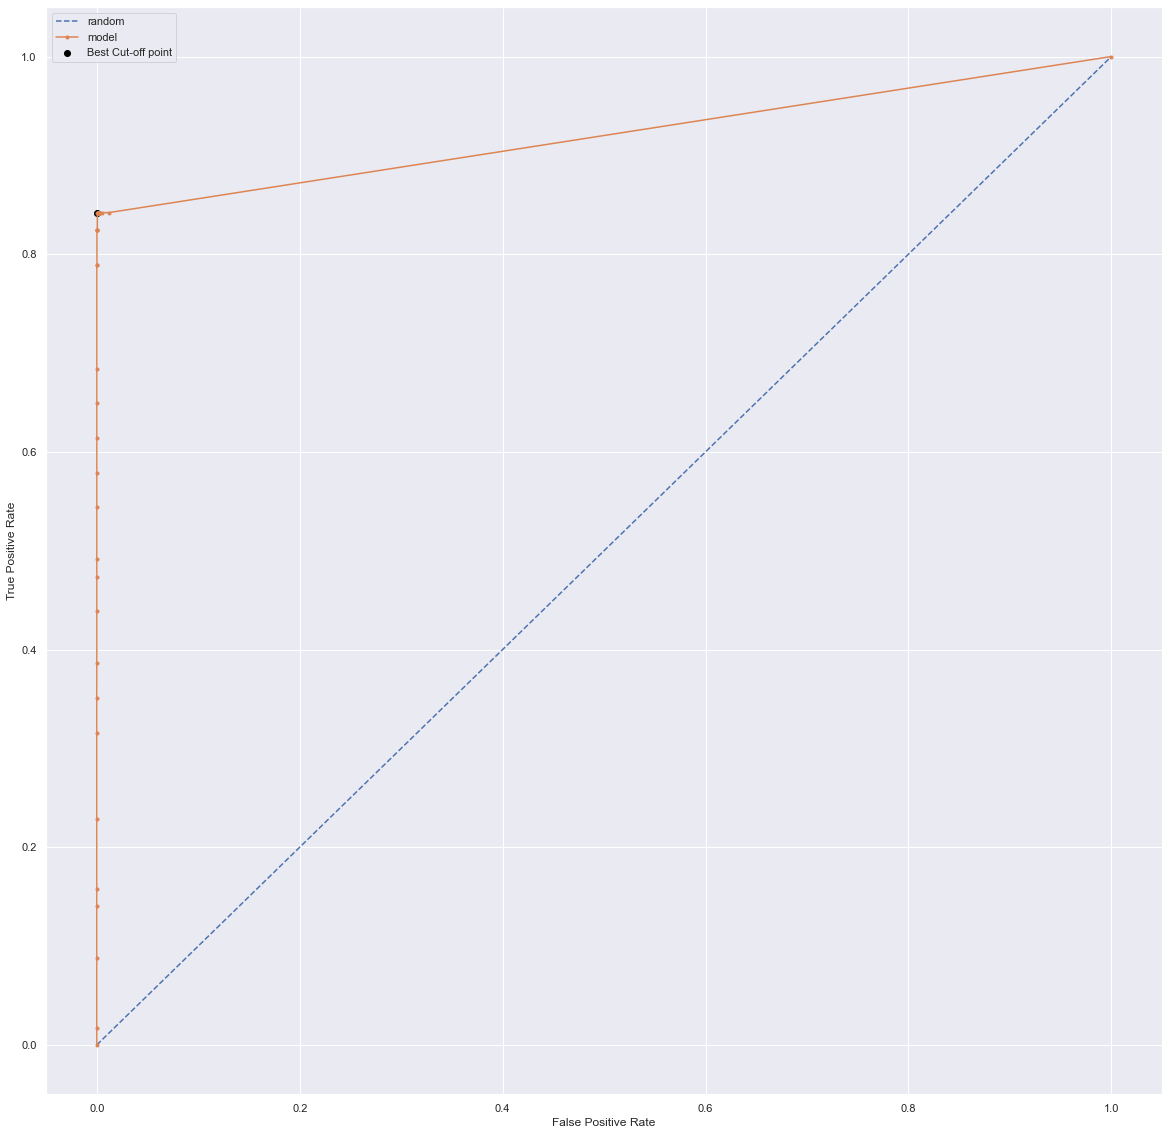

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, positive_proba_rf)
gmeans = sqrt(tpr * (1 - fpr))
ix = argmax(gmeans)
print('Best cut-off: %f, G-Mean: %.3f' % (thresholds[ix], gmeans[ix]))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot(fpr, tpr, marker='.', label='model')
plt.scatter(fpr[ix],
               tpr[ix],
               marker='o',
               color='black',
               label='Best Cut-off point')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Przyłożę też undersampling. Oversampling stosuje się gdy jedynek jest więcej.

In [42]:
X_testu = X_test
y_testu = y_test

In [47]:
undersample = us.RandomUnderSampler()
X_testu, y_testu= undersample.fit_resample(X, y)

sprawdzę czy ilości rzeczywiście się rozłożyły bardziej korzystnie.

In [48]:
print(Counter(y_test))
print(Counter(y_testu))

Counter({0: 24943, 1: 57})
Counter({0: 223, 1: 223})


In [52]:
y_pred_rf_u = rf_model.predict(X_testu)
y_pred_proba_rf_u = rf_model.predict_proba(X_testu)
positive_proba_rf_u = y_pred_proba_rf_u[:, 1]

In [53]:
print("RFu AUC score      : ", roc_auc_score(y_testu, positive_proba_rf_u))
print("RFu precision score: ", precision_score(y_testu, y_predu))
print("RFu F1 score       : ", f1_score(y_testu, y_predu))

RFu AUC score      :  0.968459048040379
RFu precision score:  1.0
RFu F1 score       :  0.9330143540669855


Zabieg się przydał, metryki się poprawiły, w szczególności precision score.